The goal of this project is to **study existing credit store patterns** as per user to be in position to decide to whether the user in question can be offered credit or not . A credit score model is a statistical tool that evaluates creditworthiness and determines the likelihood of default on credit obligations. It does evaluate various factors such as payment history , credit utilization , lenght of credit history , types of credit accounts and recent credit inquiries .The higher the credit score , the lower the credit risk of default .Lenders use credit scores when it comes to loan terms,offering interest rates , the period one takes to make the payments and ofcourse how much one can be loaned . In short , good credit scores could at the end of the day imply lower loan rates and viseversa . 

In [1]:
### Importing all the necessary libraries
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

In [2]:
credit_score_data = pd.read_csv(
    r"I:\Machine Learning Projects\Credit_Score_Data\train.csv",
    dtype={'Age': int, 'Num_Bank_Accounts':int , 'Credit_History_Age':int})

The next part is to investigate the percentage of missing data in each of the columns .This at the end will give us the ability to : 
- Inspect which columns have significant missing values .
- What else we can do with these columns , some may be important require statistical missing data imputation such as mean fill up or regression using the famour SimpleImputer Data Transform offerd by scikit-learn

In [3]:
def intitial_eda_checks(df):
    '''
    Takes df
    Checks nulls
    '''
    if df.isnull().sum().sum() > 0:
        mask_total = df.isnull().sum().sort_values(ascending=False) 
        total = mask_total[mask_total > 0]

        mask_percent = df.isnull().mean().sort_values(ascending=False) 
        percent = mask_percent[mask_percent > 0] 

        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
        print(f'Total and Percentage of NaN:\n {missing_data}')
    else: 
        print('No NaN found.')

In [4]:
intitial_eda_checks(credit_score_data) # Results indicate that the data frame credit_score_data does not have missing rows

No NaN found.


In [5]:
credit_score_data.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')

In [6]:
def delete_unimportant_features(df, feature_one, feature_two, feature_three,
                                feature_four, feature_five, feature_six,
                                feature_seven, feature_eight, feature_nine,
                                feature_ten, feature_eleven):
    '''
    This function takes in a DataFrame and removes specified columns that are not important for deciding
    a client's ability to receive credit. Names, customer_ID etc., do not play a part. Users can specify additional features to drop.
    '''
    df = df.drop(columns=[
        feature_one, feature_two, feature_three, feature_four, feature_five,
        feature_six, feature_seven, feature_eight, feature_nine, feature_ten,
        feature_eleven
    ],
                 inplace=True)
    return df

In [7]:
minimum_payment =credit_score_data.groupby('Payment_of_Min_Amount').agg({'Payment_of_Min_Amount':'count'})
minimum_payment['percentage']= (minimum_payment['Payment_of_Min_Amount']/minimum_payment['Payment_of_Min_Amount'].sum())*100
minimum_payment

Payment_of_Min_Amount  percentage
Payment_of_Min_Amount                                   
NM                                     12007      12.007
No                                     35667      35.667
Yes                                    52326      52.326

I have decided to remove `´Payment_of_Min_Amount`´ from the to be analyzed features because it contains over 10% of the data points with *NM* meaning **Not mentioned**. This percentage indicates the machine learning model accuracy will be greatly affected.

### Correlation Coefficent

In order to find the correlation between the features and the target values in the data set , we are going to use the `´pearson correlation coefficient`´.
- However , before we can go on to pearson correlate the features vs target. We need to categorize some of the features because this method only deals with numerical numbers . 

We have normial variables : This represents those categories without a natural ordering or ranking .
We also have Ordinal variables :This represents categories whose order follows a logical ordering. These include 
- Credit_Mix
- Credit Score
- Payment_Behaviour

In [8]:
#instatiate ordincal encoder
def one_encode_credit_mix(df, column_name):
    df['credit_mix_ordinal_encoded'] = df[column_name].map({
        'Good': 3,
        'Standard': 2,
        'Bad': 1
    })

In [9]:
def one_encode_credit_score(df, column_name):
    df['credit_score_ordinal_encoded'] = df[column_name].map({
        'Good': 3,
        'Standard': 2,
        'Poor': 1
    })

In [10]:
def one_encode_payment_method(df, column_name):
    df['payment_method_ordinal_encodeded'] = df[column_name].map({
        'High_spent_Small_value_payments':
        1,
        'Low_spent_Large_value_payments':
        6,
        'Low_spent_Medium_value_payments':
        5,
        'Low_spent_Small_value_payments':
        3,
        'High_spent_Medium_value_payments':
        2,
        'High_spent_Large_value_payments':
        4,
    })

In [11]:
def one_encode_Ocupation(df, column_name):
    df['Occupation_ordinal_encoded'] = df[column_name].map({
        
        'Journalist':
        1,
        'Teacher':
        2,
        'Musician':
        3,
        'Writer':
        4,
        'Mechanic':
        5,
        'Developer':
        6,
        'Entrepreneur':
        7,
        'Architect':
        8,
        'Accountant':
        9,
        'Media_Manager':
        10,
        'Scientist':
        11,
        'Manager':
        12,
        'Lawyer':
        13,
        'Doctor':
        14,
        'Engineer':
        15
    })

In [12]:
def one_encode_minimum_payment(df, column_name):
    df['Mininmum_Payment_ordinal_encodeded'] = df[column_name].map({
        'No':
        0,
        'NM':
        6,
        'Low_spent_Medium_value_payments':
        5,
        'Low_spent_Small_value_payments':
        3,
        'High_spent_Medium_value_payments':
        2,
        'High_spent_Large_value_payments':
        4,
    })

In [13]:
one_encode_credit_mix(credit_score_data, 'Credit_Mix')
one_encode_credit_score(credit_score_data, 'Credit_Score')
one_encode_payment_method(credit_score_data, 'Payment_Behaviour')
one_encode_Ocupation(credit_score_data, 'Occupation')

In [14]:
delete_unimportant_features(credit_score_data,'ID','Customer_ID','Name','SSN','Month','Type_of_Loan','Credit_Mix','Credit_Score','Payment_Behaviour','Occupation','Payment_of_Min_Amount')
#Type_of_loan has been removed because the way the data was collected makes it impossible to collect any meaningful info

#### Applying the pearson correlation coefficient

In [15]:
pearsoncorr = credit_score_data.corr(method='pearson')
pearsoncorr

Age  Annual_Income  \
Age                               1.000000       0.091525   
Annual_Income                     0.091525       1.000000   
Monthly_Inhand_Salary             0.090636       0.998154   
Num_Bank_Accounts                -0.190415      -0.284060   
Num_Credit_Card                  -0.148567      -0.217852   
Interest_Rate                    -0.217557      -0.302352   
Num_of_Loan                      -0.213533      -0.255560   
Delay_from_due_date              -0.174119      -0.250105   
Num_of_Delayed_Payment           -0.184264      -0.286297   
Changed_Credit_Limit             -0.157254      -0.176353   
Num_Credit_Inquiries             -0.250960      -0.280242   
Outstanding_Debt                 -0.202374      -0.269319   
Credit_Utilization_Ratio          0.025492       0.175930   
Credit_History_Age                0.234618       0.272374   
Total_EMI_per_month              -0.047334       0.438106   
Amount_invested_monthly           0.071045       0.806281   
Monthly_Balance                   0.116098       0.625640   
credit_mix_ordinal_encoded        0.242942       0.342239   
credit_score_ordinal_encoded      0.160371       0.212606   
payment_method_ordinal_encodeded  0.005276       0.047992   
Occupation_ordinal_encoded       -0.010281       0.004302   

                                  Monthly_Inhand_Salary  Num_Bank_Accounts  \
Age                                            0.090636          -0.190415   
Annual_Income                                  0.998154          -0.284060   
Monthly_Inhand_Salary                          1.000000          -0.283181   
Num_Bank_Accounts                             -0.283181           1.000000   
Num_Credit_Card                               -0.216847           0.442694   
Interest_Rate                                 -0.301858           0.584302   
Num_of_Loan                                   -0.254298           0.472483   
Delay_from_due_date                           -0.249438           0.560193   
Num_of_Delayed_Payment                        -0.285360           0.601842   
Changed_Credit_Limit                          -0.176187           0.333794   
Num_Credit_Inquiries                          -0.279736           0.518323   
Outstanding_Debt                              -0.269044           0.507063   
Credit_Utilization_Ratio                       0.176092          -0.071783   
Credit_History_Age                             0.271457          -0.485331   
Total_EMI_per_month                            0.421836           0.050035   
Amount_invested_monthly                        0.807326          -0.227828   
Monthly_Balance                                0.626631          -0.286709   
credit_mix_ordinal_encoded                     0.340980          -0.723665   
credit_score_ordinal_encoded                   0.209761          -0.388165   
payment_method_ordinal_encodeded               0.047671          -0.008863   
Occupation_ordinal_encoded                     0.004488          -0.008457   

                                  Num_Credit_Card  Interest_Rate  Num_of_Loan  \
Age                                     -0.148567      -0.217557    -0.213533   
Annual_Income                           -0.217852      -0.302352    -0.255560   
Monthly_Inhand_Salary                   -0.216847      -0.301858    -0.254298   
Num_Bank_Accounts                        0.442694       0.584302     0.472483   
Num_Credit_Card                          1.000000       0.497912     0.417960   
Interest_Rate                            0.497912       1.000000     0.559156   
Num_of_Loan                              0.417960       0.559156     1.000000   
Delay_from_due_date                      0.479762       0.589185     0.501599   
Num_of_Delayed_Payment                   0.423300       0.571457     0.473919   
Changed_Credit_Limit                     0.255495       0.370156     0.374602   
Num_Credit_Inquiries                     0.459429       0.632562     0.565087   
Outstan

<Axes: >

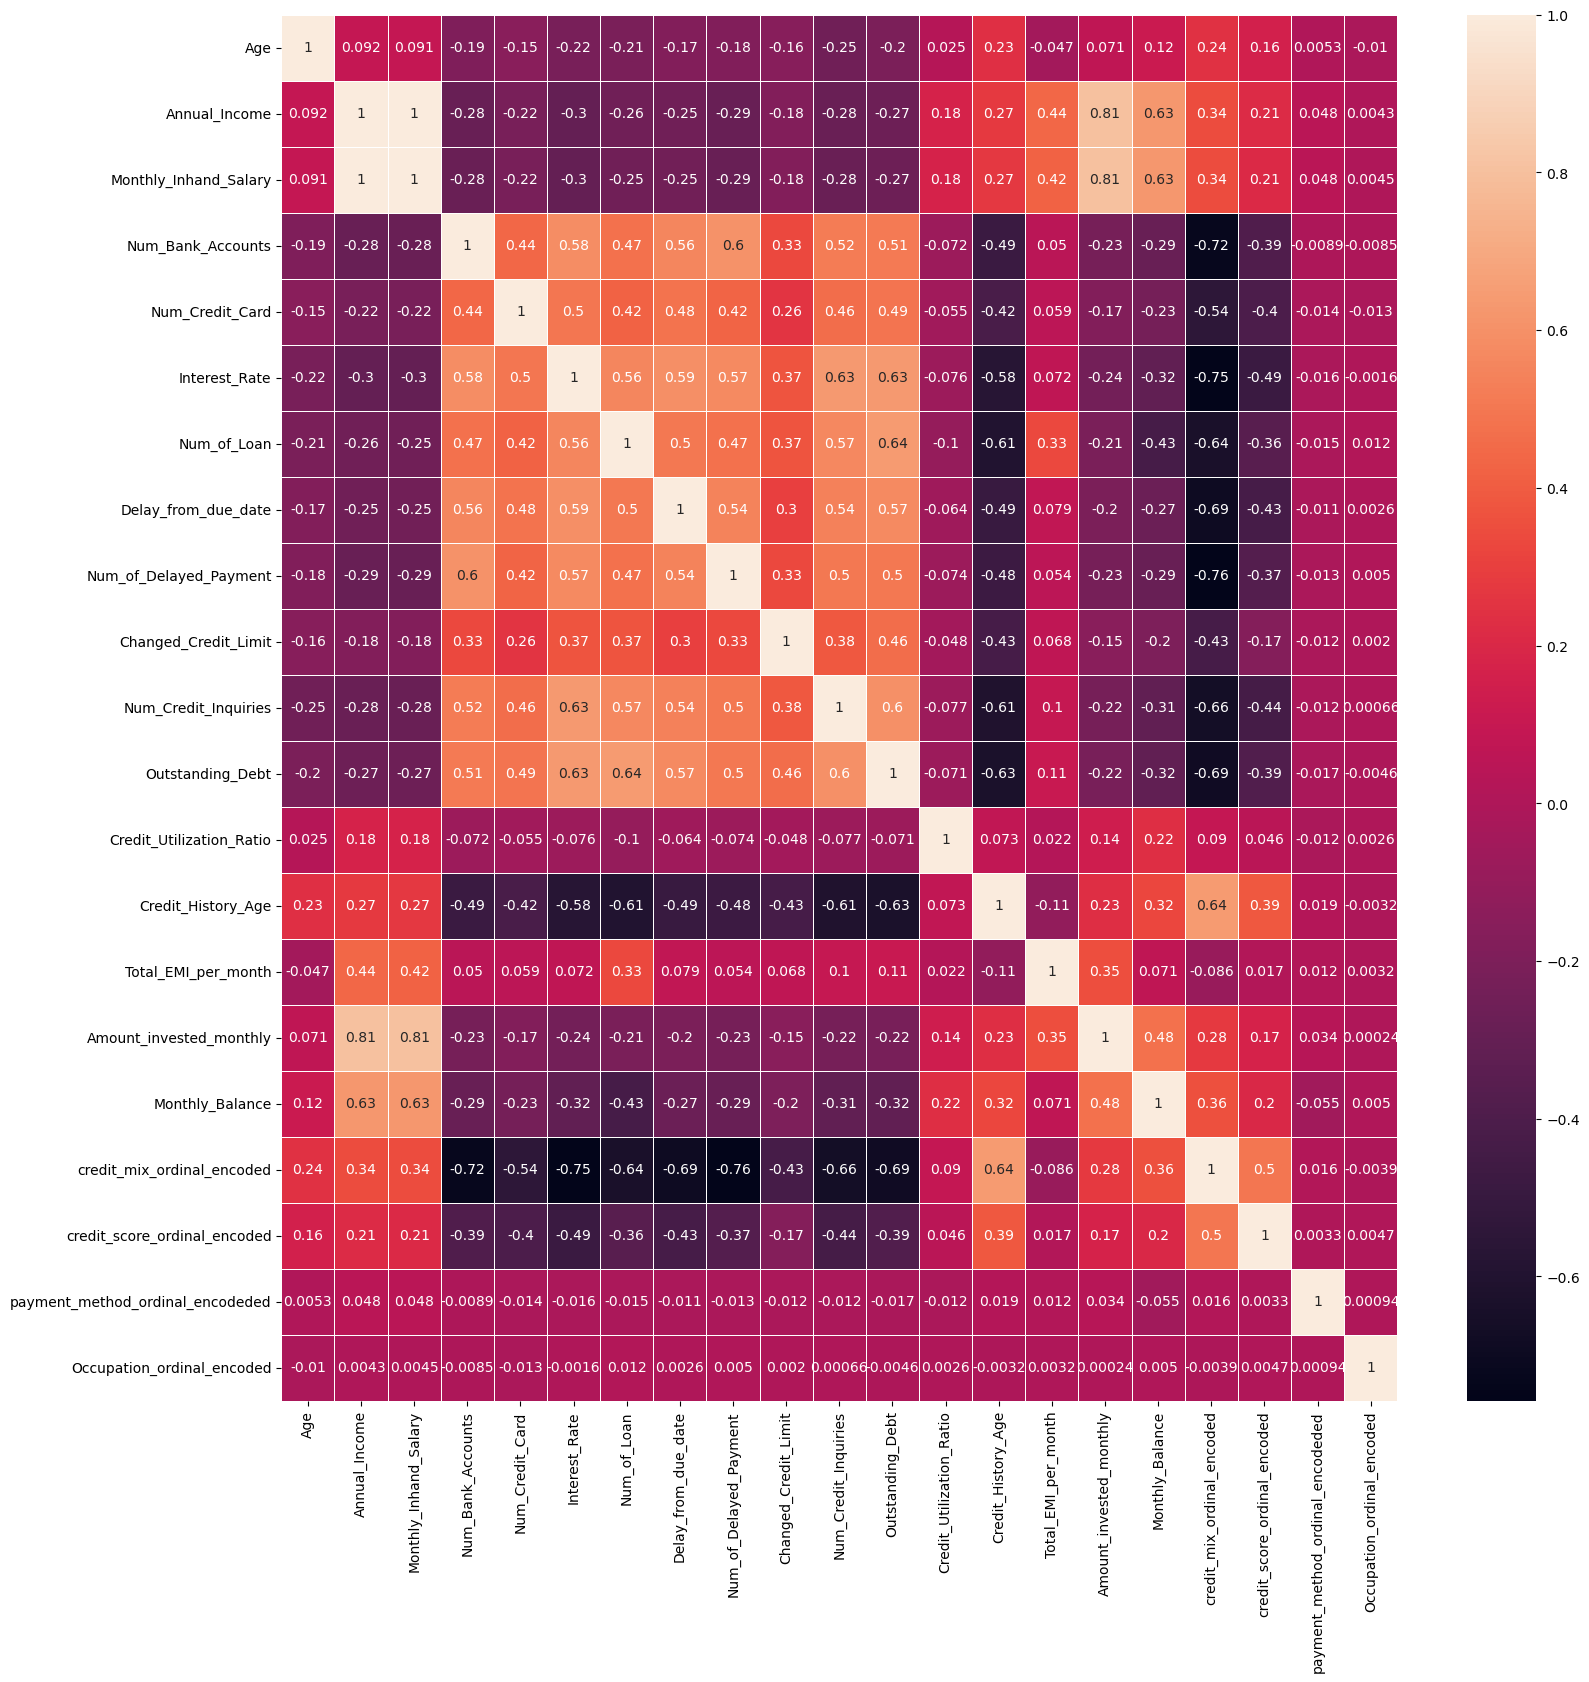

In [16]:
plt.figure(figsize=(18, 18))
sns.heatmap(pearsoncorr ,
          xticklabels = pearsoncorr.columns, 
          yticklabels = pearsoncorr.columns,
          annot = True,
          linewidth = 0.5)

It is important to understand the indepent variable in this instance represented by `´credit_score`´ aka `´credit_score_ordinal_encoded`´ represented by Credit_Score_Ordinal_encoded . In this case,I created a threshold to elimiate features without a strong correlation coefficient. It is also worth noting that the darker the color, the stronger the relation. A case in point is positive relation between **credit mix** and **credit score**. We also see how an outstanding debt affects the credit score one recieves. 

In [17]:
threshold = 0.3
a = abs(pearsoncorr['credit_score_ordinal_encoded'])
result = a[a > threshold]
result

Num_Bank_Accounts               0.388165
Num_Credit_Card                 0.404435
Interest_Rate                   0.485409
Num_of_Loan                     0.358355
Delay_from_due_date             0.431446
Num_of_Delayed_Payment          0.372978
Num_Credit_Inquiries            0.435113
Outstanding_Debt                0.386525
Credit_History_Age              0.388788
credit_mix_ordinal_encoded      0.498673
credit_score_ordinal_encoded    1.000000
Name: credit_score_ordinal_encoded, dtype: float64

### Pictorial representation of how some features correlate with the credit score

#### Number of credit cards

In [18]:
credit_score_data['credit_score_ordinal_encoded'].unique()

array([3, 2, 1], dtype=int64)

In [19]:
fig = px.box(credit_score_data, 
             x="credit_score_ordinal_encoded", 
             y="Num_Credit_Card", 
             color="credit_score_ordinal_encoded",
             title="Credit Scores Based on Number of credit cards one has",
             color_discrete_map={1:'red',
                                 2:'yellow',
                                 3:'green'})
fig.update_traces(quartilemethod="exclusive")
fig.show()

It is important to note that **green** represents a *good score*, **yellow** represents a *standard score* and **red** does represent a *poor score*. The results indicate a rather `´inverse relation`´ in that a user with an average of 3 credit cards is most likely to have a better credit score as compared to one with 7 credit cards indicated with red.

#### Interest rate

In [20]:
credit_score_data_interest_rate = credit_score_data.groupby('credit_score_ordinal_encoded').agg({'Interest_Rate':'mean'}).reset_index(
)
credit_score_data_interest_rate

credit_score_ordinal_encoded  Interest_Rate
0                             1      20.187116
1                             2      13.751420
2                             3       7.662329

In [21]:
fig = px.bar(credit_score_data_interest_rate,
             x='credit_score_ordinal_encoded',
             y='Interest_Rate',
            color="Interest_Rate",
             title="Credit Scores Based on Interest rates",
             color_discrete_map={1:'red',
                                 2:'yellow',
                                 3:'green'},
            height = 600 , width = 900, text_auto=True)
fig.show()

The results above indicate that credit card holders with **relatively high interest rates** are most likely to have a very low credit **scores** as compared to those with a relatively low interest rate. As shown , *blue* does indicate a good score and does correlate with the *lowest interest rate*. 

#### Delay from due date 

In [22]:
credit_score_data.columns

Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly',
       'Monthly_Balance', 'credit_mix_ordinal_encoded',
       'credit_score_ordinal_encoded', 'payment_method_ordinal_encodeded',
       'Occupation_ordinal_encoded'],
      dtype='object')

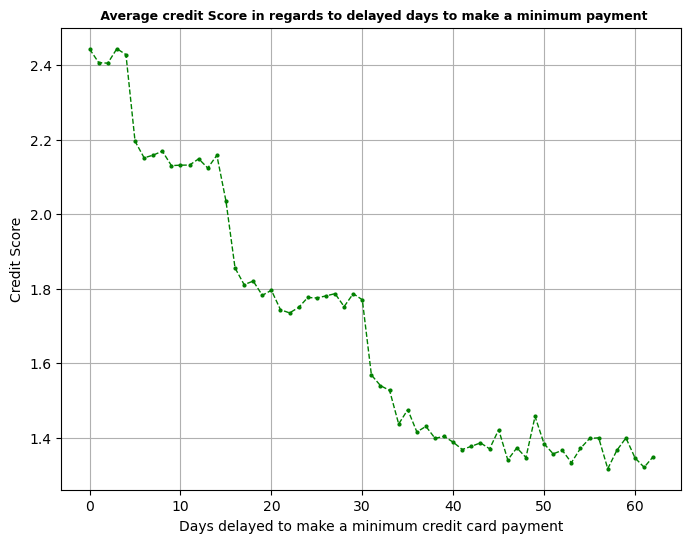

In [23]:
Delay_from_due_date_df = credit_score_data.groupby('Delay_from_due_date').agg({
    'credit_score_ordinal_encoded':
    'mean'
}).reset_index()
x = Delay_from_due_date_df['Delay_from_due_date']
y = Delay_from_due_date_df['credit_score_ordinal_encoded']

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

plt.plot(x,
         y,
         color='green',
         marker='o',
         linestyle='dashed',
         linewidth=1,
         markersize=2)

plt.title(' Average credit Score in regards to delayed days to make a minimum payment',fontsize=9,fontweight ='bold')
plt.xlabel('Days delayed to make a minimum credit card payment')  # Use function calls, not assignment
plt.ylabel('Credit Score')  # Use function calls, not assignment
plt.grid(True)

plt.show()

The line plot above shows that the more time a client takes to pay the **minimum credit card amount back** , the higher the chance of obtaining a v**ery low credit score**. This explains why this feature is very important in decison making .

### Machine learning Model construction

In order to build a good machine learning model , we ought to first split the data set into a 20% - 80% ration. This implies that , we split the whole data set into : 

- Training Set which consists of 80% of the data set 
- Testing Set which consists of the remaining 20%

`´The natural of the problem we are facing falls under classification. This is because our problem has two values : that is 1 and 0 . The goal is to be able to classify clients based on the provided features as to whether they are more or less deserving of getting a loan based on their Credit Score.`´

###  Applying the Random-Forest-Regressor
- The famous Random Fores is an ensemble learning method which combines variations of decision trees to produce a more accurate and robust model . A large number of decision trees are created and each trained a random subset of features. At the end of the day , the final result is a combination of all the individual trees. 
- Reasons for its worldwide choice has to do with its ability to handle both categorical and numerical data . Its outstanding robustness to outliers and its ability to handle missing values . 

In [27]:
RF_DataSet = credit_score_data[[
    'Num_Bank_Accounts',
    'Num_Credit_Card',
    'Interest_Rate',
    'Num_of_Loan',
    'Delay_from_due_date',
    'Num_of_Delayed_Payment',
    'Outstanding_Debt',
    'Credit_History_Age',
    'credit_mix_ordinal_encoded',
    'credit_score_ordinal_encoded',
    'Num_Credit_Inquiries'
]]

In [28]:
predictors = RF_DataSet[[
    'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
    'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Outstanding_Debt',
    'Credit_History_Age', 'credit_mix_ordinal_encoded', 'Num_Credit_Inquiries'
]]

In [29]:
target = predictors = RF_DataSet[['credit_score_ordinal_encoded']]

In [35]:
#Using scikit-learn a random split into training and test sets can be computed with the train_test_split helper function
x_train, x_test, y_train, y_test = train_test_split(predictors,
                                                    target,
                                                    test_size=0.2, #only 20% is left for testing
                                                    random_state=42)

# Then split the training set further into training and cross-validation sets
x_train, x_cv, y_train, y_cv = train_test_split(
    x_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Ensure 'y_train' and 'y_cv' are 1D arrays
y_train = y_train.values.reshape(-1, 1)
y_cv = y_cv.values.reshape(-1, 1)

# Continue with the rest of your code for k-fold cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=7)

# Checking the scores by using our function
algos = [
    LinearRegression, KNeighborsRegressor, RandomForestRegressor, Lasso,
    ElasticNet, DecisionTreeRegressor
]
algorithm_scores = []
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score


def scores(algorithm, x_train, y_train, x_cv, y_cv):
    # Initialize the model
    model = algorithm()

    # Train the model on the training set
    model.fit(x_train, y_train)

    # Make predictions on the training set
    y_train_pred = model.predict(x_train)

    # Make predictions on the cross-validation set
    y_cv_pred = model.predict(x_cv)

    # Calculate R-squared scores
    train_score = r2_score(y_train, y_train_pred)
    cv_score = r2_score(y_cv, y_cv_pred)

    # Calculate Mean Squared Error
    mean_error_train = mean_squared_error(y_train, y_train_pred)
    mean_error_cv = mean_squared_error(y_cv, y_cv_pred)

    # Calculate the Adjusted R-sqaured scores
    train_score_adjusted_r_squared = 1 - (1 - train_score) * (
        len(y_train) - 1) / (len(y_train) - x_train.shape[1] - 1)

    return train_score, train_score_adjusted_r_squared, cv_score, mean_error_cv


for algo in algos:
    avg_train_score, train_score_adjusted_r_squared, avg_cv_score, avg_mean_error = scores(
        algo, x_train.values, y_train, x_cv.values, y_cv)
    algorithm_scores.append(
        (algo.__name__, avg_train_score, train_score_adjusted_r_squared,
         avg_cv_score, avg_mean_error))
    print(
        f'{algo.__name__} Average Training R-squared score: {avg_train_score}')
    print(
        f'{algo.__name__} Average Adjusted Training R-squared score: {train_score_adjusted_r_squared}'
    )
    print(
        f'{algo.__name__} Average Cross-Validation R-squared score: {avg_cv_score}'
    )
    print(f'{algo.__name__} Average Mean Error: {avg_mean_error}')

# Optionally, you can print or analyze the scores
print("Algorithm Scores:")
for algo_name, avg_train_score, train_score_adjusted_r_squared, avg_cv_score, avg_mean_error in algorithm_scores:
    print(f'{algo_name}:')
    print(f'  Average Training Score: {avg_train_score}')
    print(
        f'  Adjusted Training R-squared score: {train_score_adjusted_r_squared}'
    )
    print(f'  Average Cross-Validation Score: {avg_cv_score}')
    print(f'  Average Mean Error: {avg_mean_error}')

LinearRegression Average Training R-squared score: 1.0
LinearRegression Average Adjusted Training R-squared score: 1.0
LinearRegression Average Cross-Validation R-squared score: 1.0
LinearRegression Average Mean Error: 1.8648149672113075e-27
KNeighborsRegressor Average Training R-squared score: 1.0
KNeighborsRegressor Average Adjusted Training R-squared score: 1.0
KNeighborsRegressor Average Cross-Validation R-squared score: 1.0
KNeighborsRegressor Average Mean Error: 0.0


C:\Users\enock.mugabi\AppData\Local\Temp\ipykernel_16596\985451548.py:34: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor Average Training R-squared score: 1.0
RandomForestRegressor Average Adjusted Training R-squared score: 1.0
RandomForestRegressor Average Cross-Validation R-squared score: 1.0
RandomForestRegressor Average Mean Error: 0.0
Lasso Average Training R-squared score: 0.0
Lasso Average Adjusted Training R-squared score: -1.6667222240807078e-05
Lasso Average Cross-Validation R-squared score: -5.114725879717952e-06
Lasso Average Mean Error: 0.44973857777777776
ElasticNet Average Training R-squared score: 0.0
ElasticNet Average Adjusted Training R-squared score: -1.6667222240807078e-05
ElasticNet Average Cross-Validation R-squared score: -5.114725879717952e-06
ElasticNet Average Mean Error: 0.44973857777777776
DecisionTreeRegressor Average Training R-squared score: 1.0
DecisionTreeRegressor Average Adjusted Training R-squared score: 1.0
DecisionTreeRegressor Average Cross-Validation R-squared score: 1.0
DecisionTreeRegressor Average Mean Error: 0.0
Algorithm Scores:
LinearRe

- The results above indicate the **Decision Tree Regressor, KNeighborsRegressor, RandomForestRegressor**, and even **LinearRegression** are showing perfect R_sqaured scores of 1.0 for both training and cross-validation datasets, with a mean error of 0.0 . This is most likely due to the fact that the results are rather Ideal given the perfect predictions with no error . 

#### The Random Forest Regressor implemented. 

In [37]:
model = RandomForestRegressor(n_estimators=50, oob_score = True,n_jobs=3,random_state =42, min_samples_leaf =8,max_depth=4)

In [38]:
model.fit(x_test,y_test)

C:\Users\enock.mugabi\AppData\Local\Temp\ipykernel_16596\830984753.py:1: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor(max_depth=4, min_samples_leaf=8, n_estimators=50,
                      n_jobs=3, oob_score=True, random_state=42)

### Showing the Trees created

 **Plan for tomorrow :**

- Bayesian algarithm and incoperating that into this machine learning model
- This has to be done tomorrow and uplodated to the new pc .Also ensure that all the notebooks are saved and moved safely and nicely. 
- It would be a smart idea if I apply onehot and ordinal encoding . 